# Denoising Diffusion Probalistic Models for Cosmological Field Emulation / Parameter Inference
Denoising Diffusion Probalistic Models (DDPM) are a type of generative model that trains on image data to generate similar image outputs. It works by adding random noise to the data in series of time steps, learning the denoising process, and sampling to return a generated image.

In [13]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import ndimage

import tensorflow as tf
from tensorflow import keras
import keras
from keras import layers

# import tensorflow_datasets as tfds

## Data Exploration
I will use a DDPM to create a cosmological field emulator, which replicates cosmic fields and summary statistics based on large-scale heavy hydrodynamical simulations. I will follow the following paper: https://ml4physicalsciences.github.io/2023/files/NeurIPS_ML4PS_2023_182.pdf

Mudur et al. uses the IllustrisTNG Cold Dark Matter (CDM) density fields at z=0 from the CAMELS Multifield Dataset (CMD).

In [2]:
# Load data
data = np.load('Maps_Mcdm_IllustrisTNG_LH_z=0.00.npy', mmap_mode='r')
params = np.loadtxt('params_LH_IllustrisTNG.txt')

In [3]:
param_ranges = [[0.1, 0.5], [0.6, 1.0]]
labels1 = np.array([[p]*15 for p in params[:,0]]).flatten()
labels2 = np.array([[p]*15 for p in params[:,1]]).flatten()
labels = np.array([labels1, labels2]).transpose()
for i in range(len(param_ranges)):
    labels[:,i] = (labels[:,i] - param_ranges[i][0]) / (param_ranges[i][1] - param_ranges[i][0])
print(labels.shape)
print(data.shape)

(15000, 2)
(15000, 256, 256)


In [4]:
# Hyperparameters
batch_size = 32
num_epochs = 60
total_timesteps = 1000
norm_groups = 8 # Number of groups used in GroupNormalization layer
learning_rate = 2e-4

img_size = 64
img_channels = 1
clip_min = -1.0
clip_max = 1.0
y_dim = 2

first_conv_channels = 64
channel_multiplier = [1, 2, 4, 8]
widths = [first_conv_channels * mult for mult in channel_multiplier]
has_attention = [False, False, True, True]
num_res_blocks = 2

In [5]:
def data_gen():
    for i in range(15000):
        d = ndimage.zoom(np.log10(data[i]), img_size/256)
        yield np.expand_dims(d, -1), labels[i]

In [6]:
ds = tf.data.Dataset.from_generator(
    data_gen,
    output_signature=(
        tf.TensorSpec(shape=(img_size, img_size, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(2,), dtype=tf.float32),
    )
)

I0000 00:00:1730089504.006850   19412 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730089504.349043   19412 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730089504.349097   19412 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730089504.351741   19412 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730089504.351921   19412 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

[0.309   0.979   3.11234 1.12194 0.6685  0.53182]
[0.3026  0.9394  3.42001 3.96137 1.03311 1.1607 ]
[0.4282  0.753   0.70613 0.37423 1.96292 0.6272 ]
[0.1906  0.6286  1.60882 0.39887 0.86634 0.86634]
[0.1382  0.6874  1.19914 0.27586 0.82188 0.917  ]
[0.3114  0.7006  2.03073 0.34532 1.53368 1.55725]
[0.2878  0.785   1.8226  0.77378 1.60993 0.98282]
[0.4926  0.7422  1.89474 0.44319 0.79719 1.19168]
[0.389   0.7778  0.28678 0.2581  1.69937 1.03598]


2024-10-27 21:25:06.331194: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


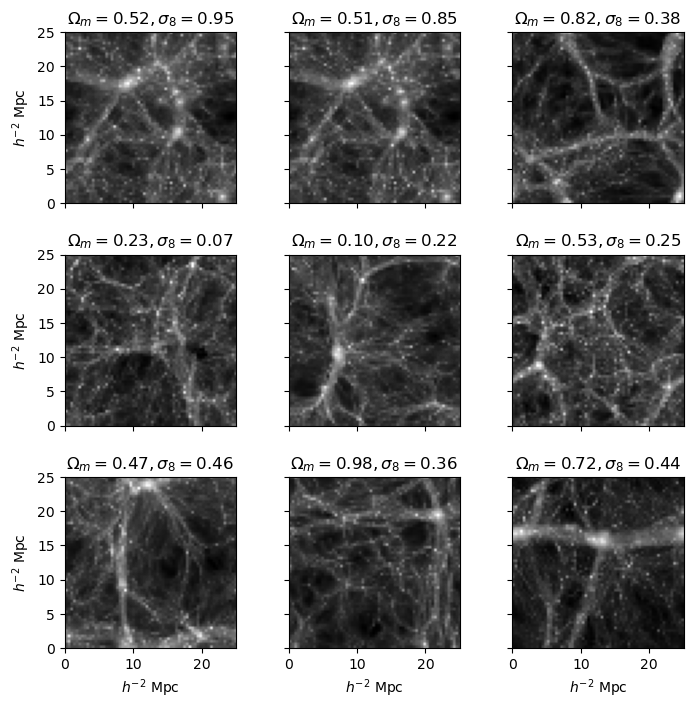

In [7]:
fig, ax = plt.subplots(3,3,figsize=(8,8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.3, hspace=0.3)
for d, (map, y) in enumerate(ds.take(9*15)):
    if d % 15 != 0:
        continue
    d = d // 15
    i, j = np.unravel_index(d, (3,3))
    ax[i,j].imshow(map[:,:,0], cmap='gray', origin='lower', extent=[0, 25, 0, 25])
    ax[i,j].set(title=rf'$\Omega_m = {y[0]:.2f}, \sigma_8 = {y[1]:.2f}$')
    for i in range(3):
        ax[i,0].set(ylabel=r'$h^{-2}$ Mpc')
        ax[2,i].set(xlabel=r'$h^{-2}$ Mpc')
    param = params[d]
    print(param)
fig.savefig('plots/grid.png', dpi=300)

## Building the model
I will attempt to replicate the DDPM in Mudur et al. using a Keras framework, based on a tutorial (https://keras.io/examples/generative/ddpm/). I will follow the tutorial to build the model, then adapt the paper's hyperparameters to my model.

In [8]:
def augment(img):
    'Flips or rotates image randomly'
    img = tf.image.random_flip_left_right(img)
    # return tf.image.random_rot # IDK HOW TO ROTATE
    return img

def rescale(img):
    'Rescales pixel values to [-1, 1]'
    min, max = tf.reduce_min(img), tf.reduce_max(img)
    img = (img - min) / (max - min)
    img = img * 2 - 1
    return img

def train_preprocessing(img, y):
    'Applies augmentation and rescaling to image'
    img = augment(img)
    img = rescale(img)
    return img, y

train_ds = (
    ds.map(train_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size, drop_remainder=True)
    .shuffle(batch_size*2)
    .prefetch(tf.data.AUTOTUNE)
)


In [9]:
# # Load the dataset
# (ds,) = tfds.load('oxford_flowers102', split=['train'], with_info=False, shuffle_files=True)


# def augment(img):
#     """Flips an image left/right randomly."""
#     return tf.image.random_flip_left_right(img)


# def resize_and_rescale(img, size):
#     """Resize the image to the desired size first and then
#     rescale the pixel values in the range [-1.0, 1.0].

#     Args:
#         img: Image tensor
#         size: Desired image size for resizing
#     Returns:
#         Resized and rescaled image tensor
#     """

#     height = tf.shape(img)[0]
#     width = tf.shape(img)[1]
#     crop_size = tf.minimum(height, width)

#     img = tf.image.crop_to_bounding_box(
#         img,
#         (height - crop_size) // 2,
#         (width - crop_size) // 2,
#         crop_size,
#         crop_size,
#     )

#     # Resize
#     img = tf.cast(img, dtype=tf.float32)
#     img = tf.image.resize(img, size=size, antialias=True)

#     # Rescale the pixel values
#     img = img / 127.5 - 1.0
#     img = tf.clip_by_value(img, clip_min, clip_max)
#     return img


# def train_preprocessing(x):
#     img = x["image"]
#     img = resize_and_rescale(img, size=(img_size, img_size))
#     img = augment(img)
#     return img


# train_ds = (
#     ds.map(train_preprocessing, num_parallel_calls=tf.data.AUTOTUNE)
#     .batch(batch_size, drop_remainder=True)
#     .shuffle(batch_size * 2)
#     .prefetch(tf.data.AUTOTUNE)
# )

In [10]:
class GaussianDiffusion:
    def __init__(self, beta_start=1e-4, beta_end=0.02, timesteps=1000, clip_min=-1.0, clip_max=1.0):
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.timesteps = timesteps
        self.clip_min = clip_min
        self.clip_max = clip_max

        self.betas = betas = np.linspace(beta_start, beta_end, timesteps, dtype=np.float64)
        self.num_timesteps = int(timesteps)

        alphas = 1.0 - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])

        self.betas = tf.constant(betas, dtype=tf.float32)
        self.alphas_cumprod = tf.constant(alphas_cumprod, dtype=tf.float32)
        self.alphas_cumprod_prev = tf.constant(alphas_cumprod_prev, dtype=tf.float32)

        self.sqrt_alphas_cumprod = tf.constant(
            np.sqrt(alphas_cumprod), dtype=tf.float32
        )

        self.sqrt_one_minus_alphas_cumprod = tf.constant(
            np.sqrt(1.0 - alphas_cumprod), dtype=tf.float32
        )

        self.log_one_minus_alphas_cumprod = tf.constant(
            np.log(1.0 - alphas_cumprod), dtype=tf.float32
        )

        self.sqrt_recip_alphas_cumprod = tf.constant(
            np.sqrt(1.0 / alphas_cumprod), dtype=tf.float32
        )
        self.sqrt_recipm1_alphas_cumprod = tf.constant(
            np.sqrt(1.0 / alphas_cumprod - 1), dtype=tf.float32
        )

        posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        self.posterior_variance = tf.constant(posterior_variance, dtype=tf.float32)

        self.posterior_log_variance_clipped = tf.constant(
            np.log(np.maximum(posterior_variance, 1e-20)), dtype=tf.float32
        )

        self.posterior_mean_coef1 = tf.constant(
            betas * np.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod), dtype=tf.float32
        )

        self.posterior_mean_coef2 = tf.constant(
            (1.0 - alphas_cumprod_prev) * np.sqrt(alphas) / (1.0 - alphas_cumprod), dtype=tf.float32
        )

    def _extract(self, a, t, x_shape):
        batch_size = x_shape[0]
        out = tf.gather(a, t)
        return tf.reshape(out, [batch_size, 1, 1, 1])

    def q_mean_variance(self, x_start, t):
        x_start_shape = tf.shape(x_start)
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start_shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start_shape)
        return mean, variance, log_variance

    def q_sample(self, x_start, t, noise):
        x_start_shape = tf.shape(x_start)
        return (
            self._extract(self.sqrt_alphas_cumprod, t, x_start_shape) * x_start
            + self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start_shape) * noise
        )

    def predict_start_from_noise(self, x_t, t, noise):
        x_t_shape = tf.shape(x_t)
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t_shape) * x_t
            - self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t_shape) * noise
        )

    def q_posterior(self, x_start, x_t, t):
        x_t_shape = tf.shape(x_t)
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t_shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t_shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t_shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t_shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, pred_noise, x, t, clip_denoised=True):
        x_recon = self.predict_start_from_noise(x, t, pred_noise)
        if clip_denoised:
            x_recon = tf.clip_by_value(x_recon, self.clip_min, self.clip_max)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_recon, x, t)
        return model_mean, posterior_variance, posterior_log_variance

    def p_sample(self, pred_noise, x, t, clip_denoised=True):
        model_mean, _, model_log_variance = self.p_mean_variance(pred_noise, x, t, clip_denoised)
        noise = tf.random.normal(shape=x.shape, dtype=x.dtype)
        nonzero_mask = tf.reshape(
            1 - tf.cast(tf.equal(t, 0), tf.float32), [tf.shape(x)[0], 1, 1, 1]
        )
        return model_mean + nonzero_mask * tf.exp(0.5 * model_log_variance) * noise


In [11]:
def kernel_init(scale):
    scale = max(scale, 1e-10)
    return keras.initializers.VarianceScaling(
        scale, mode='fan_avg', distribution='uniform'
    )

class AttentionBlock(layers.Layer):
    def __init__(self, units, groups=8, **kwargs):
        self.units = units
        self.groups = groups
        super().__init__(**kwargs)

        self.norm = layers.GroupNormalization(groups=groups)
        self.query = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.key = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.value = layers.Dense(units, kernel_initializer=kernel_init(1.0))
        self.proj = layers.Dense(units, kernel_initializer=kernel_init(1.0))

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        height = tf.shape(inputs)[1]
        width = tf.shape(inputs)[2]
        scale = tf.cast(self.units, tf.float32) ** (-0.5)

        inputs = self.norm(inputs)
        q = self.query(inputs)
        k = self.key(inputs)
        v = self.value(inputs)

        attn_score = tf.einsum('bhwc, bHWc->bhwHW', q, k) * scale
        attn_score = tf.reshape(attn_score, [batch_size, height, width, height*width])
        attn_score = tf.nn.softmax(attn_score, -1)
        attn_score = tf.reshape(attn_score, [batch_size, height, width, height, width])

        proj = tf.einsum('bhwHW,bHWc->bhwc', attn_score, v)
        proj = self.proj(proj)
        return inputs + proj

class TimeEmbedding(layers.Layer):
    def __init__(self, dim, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.half_dim = dim // 2
        self.emb = math.log(10000) / (self.half_dim - 1)
        self.emb = tf.exp(tf.range(self.half_dim, dtype=tf.float32) * -self.emb)

    def call(self, inputs):
        inputs = tf.cast(inputs, dtype=tf.float32)
        emb = inputs[:, None] * self.emb[None, :]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)
        return emb

def ResidualBlock(width, groups=8, activation_fn=keras.activations.swish):
    def apply(inputs):
        x, t, y = inputs
        input_width = x.shape[3]

        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(
                width, kernel_size=1, kernel_initializer=kernel_init(1.0)
            )(x)

        temb = activation_fn(t)
        temb = layers.Dense(width, kernel_initializer=kernel_init(1.0))(temb)[:,None,None,:]

        yemb = activation_fn(y)
        yemb = layers.Dense(width, kernel_initializer=kernel_init(1.0))(yemb)[:,None,None,:]

        x = layers.GroupNormalization(groups=groups)(x)
        x = activation_fn(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(1.0)
        )(x)

        x = layers.Add()([x, temb, yemb])
        x = layers.GroupNormalization(groups=groups)(x)
        x = activation_fn(x)

        x = layers.Conv2D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(0.0)
        )(x)
        x = layers.Add()([x, residual])
        return x

    return apply

# class SymmetricPadding2D(layers.Layer):
#     def __init__(self, output_dim, padding=[1,1],
#                  data_format="channels_last", **kwargs):
#         self.output_dim = output_dim
#         self.data_format = data_format
#         self.padding = padding
#         super(SymmetricPadding2D, self).__init__(**kwargs)

#     def build(self, input_shape):
#         super(SymmetricPadding2D, self).build(input_shape)

#     def call(self, inputs):
#         if self.data_format is "channels_last":
#             #(batch, depth, rows, cols, channels)
#             pad = [[0,0]] + [[i,i] for i in self.padding] + [[0,0]]
#         elif self.data_format is "channels_first":
#             #(batch, channels, depth, rows, cols)
#             pad = [[0, 0], [0, 0]] + [[i,i] for i in self.padding]

#         if K.backend() == "tensorflow":
#             import tensorflow as tf
#             paddings = tf.constant(pad)
#             out = tf.pad(inputs, paddings, "REFLECT")
#         else:
#             raise Exception("Backend " + K.backend() + "not implemented")
#         return out

#     def compute_output_shape(self, input_shape):
#         return (input_shape[0], self.output_dim)

def DownSample(width):
    def apply(x):
        x = layers.Conv2D(
            width,
            kernel_size=3,
            strides=2,
            padding='same',
            kernel_initializer=kernel_init(1.0)
        )(x)
        return x

    return apply

def UpSample(width, interpolation='nearest'):
    def apply(x):
        x = layers.UpSampling2D(size=2, interpolation='nearest')(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", kernel_initializer=kernel_init(1.0)
        )(x)
        return x

    return apply

def TimeMLP(units, activation_fn=keras.activations.swish):
    def apply(inputs):
        temb = layers.Dense(
            units, activation=activation_fn, kernel_initializer=kernel_init(1.0)
        )(inputs)
        temb = layers.Dense(units, kernel_initializer=kernel_init(1.0))(temb)
        return temb

    return apply

def build_model(img_size, img_channels, widths, has_attention, y_dim=2, num_res_blocks=2, norm_groups=8, interpolation='nearest', activation_fn=keras.activations.swish):
    image_input = layers.Input(
        shape=(img_size, img_size, img_channels), name='image_input'
    )
    time_input = keras.Input(shape=(), dtype=tf.int64, name='time_input')
    label_input = keras.Input(shape=(y_dim,), dtype=tf.float32, name='label_input')

    x = layers.Conv2D(
        first_conv_channels,
        kernel_size=(3,3),
        padding='same',
        kernel_initializer=kernel_init(1.0)
    )(image_input)

    temb = TimeEmbedding(dim=first_conv_channels*4)(time_input)
    temb = TimeMLP(units=first_conv_channels*4, activation_fn=activation_fn)(temb)

    yemb = TimeMLP(units=first_conv_channels*4, activation_fn=activation_fn)(label_input)

    skips = [x]

    # DownBlock
    for i in range(len(widths)):
        for _ in range(num_res_blocks):
            x = ResidualBlock(widths[i], norm_groups, activation_fn)([x, temb, yemb])
            if has_attention[i]:
                x = AttentionBlock(widths[i], norm_groups)(x)
            skips.append(x)

        if widths[i] != widths[-1]:
            x = DownSample(widths[i])(x)
            skips.append(x)

    # MiddleBlock
    x = ResidualBlock(widths[-1], norm_groups, activation_fn)([x, temb, yemb])
    x = AttentionBlock(widths[-1], norm_groups)(x)
    x = ResidualBlock(widths[-1], norm_groups, activation_fn)([x, temb, yemb])

    # UpBlock
    for i in reversed(range(len(widths))):
        for _ in range(num_res_blocks + 1):
            x = layers.Concatenate(axis=-1)([x, skips.pop()])
            x = ResidualBlock(widths[i], norm_groups, activation_fn)([x, temb, yemb])
            if has_attention[i]:
                x = AttentionBlock(widths[i], norm_groups)(x)

        if i != 0:
            x = UpSample(widths[i], interpolation)(x)

    # EndBlock
    x = layers.GroupNormalization(norm_groups)(x)
    x = activation_fn(x)
    x = layers.Conv2D(1, (3, 3), padding='same', kernel_initializer=kernel_init(1.0))(x)
    return keras.Model([image_input, time_input, label_input], x, name='unet')


In [20]:
@keras.saving.register_keras_serializable()
class DiffusionModel(keras.Model):
    def __init__(self, network, ema_network, timesteps, gdf_util, ema=0.999, **kwargs):
        super().__init__(**kwargs)
        self.network = network
        self.ema_network = ema_network
        self.timesteps = timesteps
        self.gdf_util = gdf_util
        self.ema = ema

    def train_step(self, images):
        images, y = images
        batch_size = tf.shape(images)[0]
        t = tf.random.uniform(
            minval=0, maxval=self.timesteps, shape=(batch_size,), dtype=tf.int64
        )

        with tf.GradientTape() as tape:
            noise = tf.random.normal(shape=tf.shape(images), dtype=images.dtype)
            images_t = self.gdf_util.q_sample(images, t, noise)
            pred_noise = self.network([images_t, t, y], training=True)
            loss = self.loss(noise, pred_noise)

        gradients = tape.gradient(loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(self.ema * ema_weight + (1 - self.ema) * weight)

        return {'loss': loss}

    def generate_images(self, num_images=16):
        samples = tf.random.normal(
            shape=(num_images, img_size, img_size, img_channels), dtype=tf.float32
        )
        y = tf.random.normal(shape=(num_images, y_dim), dtype=tf.float32)
        for t in reversed(range(0, self.timesteps)):
            tt = tf.cast(tf.fill(num_images, t), dtype=tf.int64)
            pred_noise = self.ema_network.predict(
                [samples, tt, y], verbose=0, batch_size=num_images
            )
            samples = self.gdf_util.p_sample(
                pred_noise, samples, tt, clip_denoised=True
            )
        return samples

    def plot_images(self, epoch=None, logs=None, num_rows=2, num_cols=8, figsize=(12,5)):
        """Utility to plot images using the diffusion model during training."""
        generated_samples = self.generate_images(num_images=num_rows * num_cols)
        # generated_samples = (
        #     tf.clip_by_value(generated_samples * 127.5 + 127.5, 0.0, 255.0)
        #     .numpy()
        #     .astype(np.float32)
        # )

        _, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
        for i, image in enumerate(generated_samples):
            if num_rows == 1:
                ax[i].imshow(image)
                ax[i].axis("off")
            else:
                ax[i // num_cols, i % num_cols].imshow(image)
                ax[i // num_cols, i % num_cols].axis("off")

        plt.tight_layout()
        plt.show()
    
    # def get_config(self):
    #     config = super.get_config() 

In [26]:
network = build_model(img_size, img_channels, widths, has_attention, y_dim, num_res_blocks, norm_groups, keras.activations.swish)
ema_network = build_model(img_size, img_channels, widths, has_attention, y_dim, num_res_blocks, norm_groups, keras.activations.swish)
ema_network.set_weights(network.get_weights())

gdf_util = GaussianDiffusion(timesteps=total_timesteps)

model = DiffusionModel(network, ema_network, total_timesteps, gdf_util)

model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate)
)


In [40]:
model.fit(
    train_ds,
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[
        keras.callbacks.ModelCheckpoint(filepath='models5_2/model0_at_epoch_{epoch}.keras'),
        # keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
    ]
)

Epoch 1/60
    468/Unknown 156s 325ms/step - loss: 0.0563

/home/khong/miniconda3/envs/astr278/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
/home/khong/miniconda3/envs/astr278/lib/python3.12/site-packages/keras/src/saving/saving_api.py:102: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


468/468 ━━━━━━━━━━━━━━━━━━━━ 169s 352ms/step - loss: 0.0562
Epoch 2/60
468/468 ━━━━━━━━━━━━━━━━━━━━ 163s 335ms/step - loss: 0.0574
Epoch 3/60
468/468 ━━━━━━━━━━━━━━━━━━━━ 166s 341ms/step - loss: 0.0586
Epoch 4/60
468/468 ━━━━━━━━━━━━━━━━━━━━ 166s 342ms/step - loss: 0.0592
Epoch 5/60
468/468 ━━━━━━━━━━━━━━━━━━━━ 165s 341ms/step - loss: 0.0578
Epoch 6/60
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 0.0604

KeyboardInterrupt: 

In [29]:
model.save('model5.keras')

In [30]:
def generate_images(model, num_images=16, label=False):
    samples = tf.random.normal(
        shape=(num_images, img_size, img_size, 1), dtype=tf.float32
    )
    y = tf.random.uniform(shape=(num_images, 2), dtype=tf.float32, minval=0, maxval=1)
    for t in reversed(range(0, model.timesteps)):
        tt = tf.cast(tf.fill(num_images, t), dtype=tf.int64)
        inputs = [samples, tt]
        if label:
            inputs.append(y)
        pred_noise = model.ema_network.predict(
            inputs, verbose=0, batch_size=num_images
        )
        samples = model.gdf_util.p_sample(
            pred_noise, samples, tt, clip_denoised=True
        )
    return samples, y

def plot_images(epoch=None, logs=None, num_rows=2, num_cols=8, figsize=(12,5)):
    """Utility to plot images using the diffusion model during training."""
    generated_samples, y = generate_images(num_images=num_rows * num_cols)
    print(y)
    # generated_samples = (
    #     tf.clip_by_value(generated_samples * 127.5 + 127.5, 0.0, 255.0)
    #     .numpy()
    #     .astype(np.float32)
    # )

    _, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i, image in enumerate(generated_samples):
        if num_rows == 1:
            ax[i].imshow(image)
            ax[i].axis("off")
        else:
            ax[i // num_cols, i % num_cols].imshow(image)
            ax[i // num_cols, i % num_cols].axis("off")

    plt.tight_layout()
    plt.show()

In [41]:
generated_samples, y = generate_images(model, num_images=9, label=True)

In [37]:
test = tf.random.normal(
    shape=(9, img_size, img_size, 1), dtype=tf.float32
)

[0.309   0.979   3.11234 1.12194 0.6685  0.53182]
[0.3026  0.9394  3.42001 3.96137 1.03311 1.1607 ]
[0.4282  0.753   0.70613 0.37423 1.96292 0.6272 ]
[0.1906  0.6286  1.60882 0.39887 0.86634 0.86634]
[0.1382  0.6874  1.19914 0.27586 0.82188 0.917  ]
[0.3114  0.7006  2.03073 0.34532 1.53368 1.55725]
[0.2878  0.785   1.8226  0.77378 1.60993 0.98282]
[0.4926  0.7422  1.89474 0.44319 0.79719 1.19168]
[0.389   0.7778  0.28678 0.2581  1.69937 1.03598]


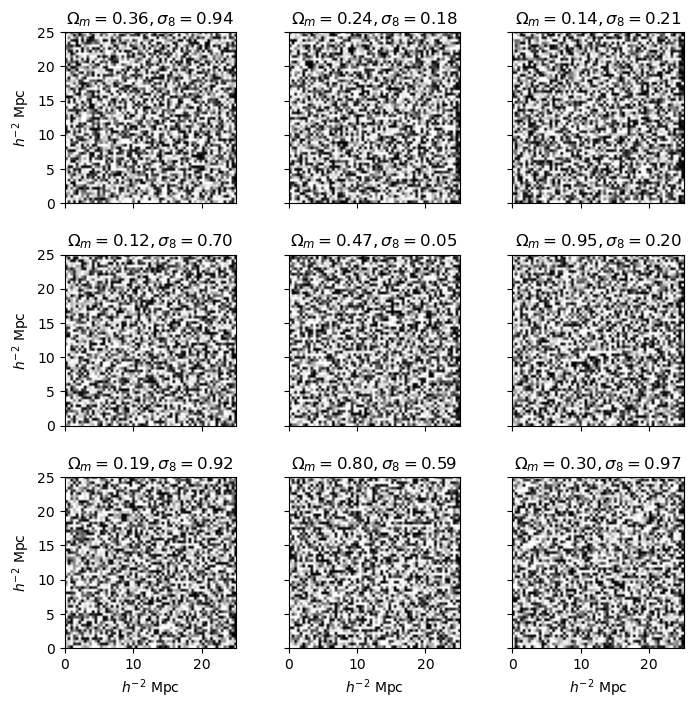

In [43]:
fig, ax = plt.subplots(3,3,figsize=(8,8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.3, hspace=0.3)
for d, map in enumerate(generated_samples):
    i, j = np.unravel_index(d, (3,3))
    ax[i,j].imshow(map[:,:,0], cmap='gray', origin='lower', extent=[0, 25, 0, 25])
    ax[i,j].set(title=rf'$\Omega_m = {y[d,0]:.2f}, \sigma_8 = {y[d,1]:.2f}$')
    for i in range(3):
        ax[i,0].set(ylabel=r'$h^{-2}$ Mpc')
        ax[2,i].set(xlabel=r'$h^{-2}$ Mpc')
    param = params[d]
    print(param)
fig.savefig('plots/grid_results.png', dpi=300)

In [24]:
model3 = keras.models.load_model('/home/khong/astr278/model5.keras')
generated_samples3, y3 = generate_images(model3, num_images=9, label=True)

TypeError: <class '__main__.DiffusionModel'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': None, 'class_name': 'DiffusionModel', 'config': {'name': 'diffusion_model_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}, 'registered_name': 'Custom>DiffusionModel', 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 0.00019999999494757503, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': {'module': 'keras.losses', 'class_name': 'MeanSquaredError', 'config': {'name': 'mean_squared_error', 'reduction': 'sum_over_batch_size'}, 'registered_name': None}, 'loss_weights': None, 'metrics': None, 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}.

Exception encountered: Unable to revive model from config. When overriding the `get_config()` method, make sure that the returned config contains all items used as arguments in the  constructor to <class '__main__.DiffusionModel'>, which is the default behavior. You can override this default behavior by defining a `from_config(cls, config)` class method to specify how to create an instance of DiffusionModel from its config.

Received config={'name': 'diffusion_model_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}

Error encountered during deserialization: DiffusionModel.__init__() missing 4 required positional arguments: 'network', 'ema_network', 'timesteps', and 'gdf_util'